#CHAT-BOT

#Описание бота: 
В боте четыре интента:

1.   Болталка на базе файла ответов mail.ru
2.   Генерация рецептов с помощью fine-tuned GPT
3.   Сообщает время
4.   На "спасибо" отвечает "Рад был помочь!"

Классификация интентов реализована с помощью алгоритма CatBoost и по ключевым словам в случае со временем и "спасибо".

GPT2 дообучена на рецептах с kaggle

В болталке используется FastText и ближайшее векторное расстояние

In [ ]:
!pip install python-telegram-bot --upgrade #restart needed

In [ ]:
!pip install pymorphy2 stop_words annoy

In [ ]:
import os
from telegram.ext  import Updater, CommandHandler, MessageHandler, Filters
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
import pickle
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd

Загрузка файлов данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/GB_NLP_04_2022/15 bot/Otvety.txt'

# Подготовка данный и обучение модели FASTTEXT для болталки

In [ ]:
assert True

#Small preprocess of the answers

question = None
written = False

with open("prepared_answers.txt", "w") as fout:
    with open(PATH, "r") as fin:
        for line in tqdm_notebook(fin):
            if line.startswith("---"):
                written = False
                continue
            if not written and question is not None:
                fout.write(question.replace("\t", " ").strip() + "\t" + line.replace("\t", " "))
                written = True
                question = None
                continue
            if not written:
                question = line.strip()
                continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

In [ ]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)

In [ ]:
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [ ]:
def preprocess_txt1(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i != ""]
    return spls

In [ ]:
assert True

# Preprocess for models fitting

sentences = []

morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)
c = 0

with open(PATH, "r") as fin:
    for line in tqdm_notebook(fin):
        spls = preprocess_txt(line)
        sentences.append(spls)
        c += 1
        if c > 500000:
            break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


0it [00:00, ?it/s]

In [ ]:
import pickle
with open('/content/drive/MyDrive/NLP_bot/sent.pkl', 'wb') as f:
   pickle.dump(sentences, f)

In [ ]:
with open('/content/drive/MyDrive/NLP_bot/sent.pkl', 'rb') as f:
  sentences = pickle.load(f)

In [ ]:
print(len(sentences))
sentences[600]

500001


['посылать', 'посылать', 'посылать', 'далёкий']

In [ ]:
sentences = [i for i in sentences if len(i) > 2]
print('start train fasttext')
modelFT = FastText(sentences=sentences, size=100, min_count=1, window=5, workers=8)
modelFT.save("ft_model")

start train fasttext


In [ ]:
modelFT.save("/content/drive/MyDrive/NLP_bot/ft_model")

In [ ]:
modelFT = FastText.load("ft_model")

In [ ]:
#modelFT = FastText.load("ft_model")
ft_index = annoy.AnnoyIndex(100 ,'angular')

index_map = {}
counter = 0

with open("prepared_answers.txt", "r") as f:
    for line in tqdm_notebook(f):
        n_ft = 0
        spls = line.split("\t")
        index_map[counter] = spls[1]
        question = preprocess_txt(spls[0])
        vector_ft = np.zeros(100)
        for word in question:
            if word in modelFT.wv:
                vector_ft += modelFT.wv[word]
                n_ft += 1
        if n_ft > 0:
            vector_ft = vector_ft / n_ft
        ft_index.add_item(counter, vector_ft)
            
        counter += 1

ft_index.build(10)
ft_index.save('speaker.ann')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

True

In [ ]:
ft_index.save('/content/drive/MyDrive/NLP_bot/speaker.ann')

True

In [ ]:
with open('/content/drive/MyDrive/NLP_bot/index_map.pkl', 'wb') as f:
   pickle.dump(index_map, f)

In [ ]:
with open('/content/drive/MyDrive/NLP_bot/index_map.pkl', 'rb') as f:
  index_map = pickle.load(f)

In [ ]:
modelFT = FastText.load("ft_model")

In [ ]:
ft_index = annoy.AnnoyIndex(100, 'angular')
ft_index.load('speaker.ann') 

True

In [ ]:
ft_index.get_nns_by_vector(np.zeros(100), 2)

[1806, 33812]

#Загрузка данных с рецептами

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d coolonce/recipes-and-interpretation-dim -p /content/drive/MyDrive/NLP_bot/

 56% 9.00M/16.0M [00:00<00:00, 26.8MB/s]
100% 16.0M/16.0M [00:00<00:00, 42.8MB/s]


In [ ]:
!ls /content/drive/MyDrive/NLP_bot/

all_recepies_inter.csv
ft_model
ft_model.trainables.syn1neg.npy
ft_model.trainables.vectors_ngrams_lockf.npy
ft_model.trainables.vectors_vocab_lockf.npy
ft_model.wv.vectors_ngrams.npy
ft_model.wv.vectors.npy
ft_model.wv.vectors_vocab.npy
recipes-and-interpretation-dim.zip
speaker.ann


In [ ]:
!unzip /content/drive/MyDrive/NLP_bot/recipes-and-interpretation-dim.zip -d /content/drive/MyDrive/NLP_bot/

Archive:  /content/drive/MyDrive/NLP_bot/recipes-and-interpretation-dim.zip
  inflating: /content/drive/MyDrive/NLP_bot/all_recepies_inter.csv  


In [ ]:
path_rec = '/content/drive/MyDrive/NLP_bot/'

In [ ]:
df_rec = pd.read_csv(path_rec+'all_recepies_inter.csv', sep='\t')

In [ ]:
df_rec.head()

,Unnamed: 0,name,composition,cooking_type,Инструкции,dish_type,Дата,photo,source,composition_inter
0,0,рассольник классический с перловкой и солеными...,"[{'Перловка': 0.1, 'unit': 'стак. (200 мл)'}, ...","варка,жарка",Подготовить указанные ингредиенты для приготов...,первое,05.06.2015,photo_1000menu_1.jpg,https://1000.menu/cooking/33395-rassolnik-s-pe...,"[{'product_id': 4253, 'name_source': 'Перловая..."
1,1,Суп пюре из белокочаной капусты,"[{'Капуста белокочанная': 50.0, 'unit': 'гр'},...",варка,"Необходимые ингредиенты\r\nНарезаем лук, морко...",первое,27.06.2015,photo_1000menu_2.jpg,https://1000.menu/cooking/25399-sup-pure-iz-be...,"[{'product_id': 2286, 'name_source': 'Капуста ..."
2,2,Постные щи из квашеной капусты,"[{'Капуста квашеная': 116.7, 'unit': 'гр'}, {'...","варка,жарка,тушение","Честно признаюсь, у меня не было репы на момен...",первое,12.02.2013,photo_1000menu_3.jpg,https://1000.menu/cooking/5159-postnje-shchi,"[{'product_id': 0, 'name_source': 'Капуста ква..."
3,3,Тюря- простой суп быстро и вкусно,"[{'Квас': 0.2, 'unit': 'л'}, {'Лук репчатый': ...",сырое,"\r\nНачинаем мы приготовление тюри с того, что...",первое,02.03.2011,photo_1000menu_4.jpg,https://1000.menu/cooking/5085-turya,"[{'product_id': 0, 'name_source': 'Квас', 'uni..."
4,4,Фасолевый суп из красной фасоли,"[{'Вода': 0.3, 'unit': 'л'}, {'Картошка': 0.3,...",варка,Подготовить ингредиенты. Для приготовления суп...,первое,28.01.2013,photo_1000menu_5.jpg,https://1000.menu/cooking/38765-fasolevyi-sup-...,"[{'product_id': 828, 'name_source': 'Вода', 'u..."


In [ ]:
df_rec.shape

(27884, 10)

In [ ]:
data = df_rec.loc[:5000, 'Инструкции'] #ограничимся 5000 записями

In [ ]:
import re
from sklearn.model_selection import train_test_split

def build_text_files(data_json, dest_path):
    f = open(dest_path, 'w')
    data = ''
    for texts in data_json:
        summary = str(texts).strip()
        summary = re.sub(r"\s", " ", summary)
        data += summary + "  "
    f.write(data)

In [ ]:
train, test = train_test_split(data, test_size=0.15)

build_text_files(train,'train_dataset.txt')
build_text_files(test,'test_dataset.txt')

In [ ]:
print("Train dataset length: "+ str(len(train)))
print("Test dataset length: "+ str(len(test)))

Train dataset length: 4250
Test dataset length: 751


In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
#sberbank-ai/rugpt3large_based_on_gpt2
#sberbank-ai/rugpt3medium_based_on_gpt2
#sberbank-ai/rugpt3small_based_on_gpt2

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")



Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_path = 'train_dataset.txt'
test_path = 'test_dataset.txt'

#Fine-tuning предобученной GPT модели

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

def load_dataset(train_path, test_path, tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)

    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset, test_dataset, data_collator

train_dataset, test_dataset, data_collator = load_dataset(train_path, test_path, tokenizer)


/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./gpt2-chief", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6696
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 5022


Step,Training Loss
500,2.532300
1000,2.452700
1500,2.365900
2000,2.217900
2500,2.161000
3000,2.146200
3500,2.092400
4000,1.984100
4500,1.968900
5000,1.962500


Saving model checkpoint to ./gpt2-chief/checkpoint-800
Configuration saved in ./gpt2-chief/checkpoint-800/config.json
Model weights saved in ./gpt2-chief/checkpoint-800/pytorch_model.bin
Saving model checkpoint to ./gpt2-chief/checkpoint-1600
Configuration saved in ./gpt2-chief/checkpoint-1600/config.json
Model weights saved in ./gpt2-chief/checkpoint-1600/pytorch_model.bin
Saving model checkpoint to ./gpt2-chief/checkpoint-2400
Configuration saved in ./gpt2-chief/checkpoint-2400/config.json
Model weights saved in ./gpt2-chief/checkpoint-2400/pytorch_model.bin
Saving model checkpoint to ./gpt2-chief/checkpoint-3200
Configuration saved in ./gpt2-chief/checkpoint-3200/config.json
Model weights saved in ./gpt2-chief/checkpoint-3200/pytorch_model.bin
Saving model checkpoint to ./gpt2-chief/checkpoint-4000
Configuration saved in ./gpt2-chief/checkpoint-4000/config.json
Model weights saved in ./gpt2-chief/checkpoint-4000/pytorch_model.bin
Saving model checkpoint to ./gpt2-chief/checkpoint-48

TrainOutput(global_step=5022, training_loss=2.1873444914580435, metrics={'train_runtime': 1028.3138, 'train_samples_per_second': 19.535, 'train_steps_per_second': 4.884, 'total_flos': 1312208584704000.0, 'train_loss': 2.1873444914580435, 'epoch': 3.0})

In [ ]:
trainer.save_model()

Saving model checkpoint to ./gpt2-chief
Configuration saved in ./gpt2-chief/config.json
Model weights saved in ./gpt2-chief/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained(path_rec+'gpt_chf')
model.save_pretrained(path_rec+'model_gpt_chf')

tokenizer config file saved in /content/drive/MyDrive/NLP_bot/gpt_chf/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/NLP_bot/gpt_chf/special_tokens_map.json
Configuration saved in /content/drive/MyDrive/NLP_bot/model_gpt_chf/config.json
Model weights saved in /content/drive/MyDrive/NLP_bot/model_gpt_chf/pytorch_model.bin


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(path_rec+"gpt_chf")
model1 = AutoModelForCausalLM.from_pretrained(path_rec+"model_gpt_chf")

In [ ]:
prefix = "берем свежие томаты "

In [ ]:
prefix = "берем клубнику "

In [ ]:
tokens = tokenizer(prefix, return_tensors='pt')
#tokens = {k: v.to(model.device) for k, v in tokens.items()}

In [ ]:
#для теста оставляю длину +50

size = tokens['input_ids'].shape[1]
output = model1.generate( 
    **tokens, 
    #end_token=end_token_id,
    do_sample=False, 
    max_length=size+50, 
    repetition_penalty=5., 
    temperature=0.5,
    num_beams=2,
)

decoded = tokenizer.decode(output[0])
result = decoded[len(prefix):]
print(prefix + result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


берем клубнику  и добавляем ее в кипящую воду, варим до мягкости. Затем снимаем с поверхности кожицу и нарезаем небольшими кубиками.  2. В кастрюлю наливаем растительное масло, кладем сахарный песок, соль, перец


In [ ]:
def gpt_generate(prefix):
  tokens = tokenizer(prefix, return_tensors='pt')
  size = tokens['input_ids'].shape[1]
  output = model1.generate( 
      **tokens, 
      #end_token=end_token_id,
      do_sample=False, 
      max_length=size+50, 
      repetition_penalty=5., 
      temperature=0.5,
      num_beams=2,
  )

  decoded = tokenizer.decode(output[0])
  result = decoded[len(prefix):]
  return prefix + result

In [ ]:
gpt_generate(prefix)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'берем свежие томаты  2. Нарежем помидоры кубиками, а лук полукольцами.  3. В кастрюле разогреваем оливковое масло и обжариваем нарезанный лук до мягкости (около 5 минут).  4. Добавляем к луку'

# Обучение CatBoost для классификации интентов

In [ ]:
data_new = data.apply(lambda x: preprocess_txt(str(x)))

In [ ]:
data_new[:10]

0    [подготовить, указанный, ингредиент, приготовл...
1    [необходимый, ингредиент, нарезать, лук, морко...
2    [честно, признаться, репа, момент, приготовлен...
3    [начинать, приготовление, тюри, заранее, подго...
4    [подготовить, ингредиент, приготовление, суп, ...
5    [мясо, нарезать, порционный, кусочек, оставлят...
6    [брать, продукт, список, показать, фото, нагля...
7    [продукт, приготовление, турецкий, суп, булгур...
8    [приготовить, постный, гороховый, суп, подгото...
9    [подготовить, указанный, продукт, создание, су...
Name: Инструкции, dtype: object

In [ ]:
data_new.shape

(5001,)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(ngram_range=(1, 2))

In [ ]:
#!ls

In [ ]:
idxs = set(np.random.randint(0, len(index_map), len(data)))

In [ ]:
negative_texts = [" ".join(preprocess_txt(index_map[i])) for i in idxs]

In [ ]:
#negative_texts = [" ".join(i) for i in sentences[:5001]]

In [ ]:
len(negative_texts)

4991

In [ ]:
positive_texts = [" ".join(val) for val in data_new.values]

In [ ]:
len(positive_texts)

5001

In [ ]:
negative_texts[13], positive_texts[13]

('брадикардияbrbrбрадикардия медленный пульс применительно взрослый пульс 60 удар считаться брадикардия брадикардия становиться следствие целое спектр сопутствовать заболевание выраженный проявление брадикардия больной наблюдаться слабость боль область сердце холодный пот головокружение полуобморочный состояние полный потеря сознанияbrbrть основное брадикардия вызвать причинамиbrbrнеспособность синусовый узел генерировать импульс называть синдром слабость синусовый узел сссуbrплохой проведение импульсовbrчасто брадикардия бывать следствие ишемический болезнь сердце артериальный гипертензия миокардит приём некоторый лекарственный препарат эндокринный заболевание повышение уровень калий кровь повышение внутричерепной давление дрbrbrметод диагностика брадикардииbrbrэлектрокардиографияbrхолтеровский мониторированиеbrэлектрофизиологический исследованиеbrэкг телефонуbrметод лечение брадикардииbrbrединственный надёжный метод лечение брадикардия являться имплантация электрокардиостимулятораbrb

In [ ]:
dataset = negative_texts + positive_texts
labels = np.zeros(len(dataset))
labels[len(negative_texts):] = np.ones(len(positive_texts))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, stratify=labels,
                                                    random_state=13)

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
x_train_vec = vectorizer.fit_transform(X_train)
x_test_vec = vectorizer.transform(X_test)

cat_new = cat.fit(x_train_vec, y_train)

In [ ]:
input_txt = preprocess_txt('разогревать растительный масло класть подготовить репчатый лук морковь')
vect = vectorizer.transform([" ".join(input_txt)])
prediction = cat_new.predict_proba(vect)
print(prediction)

[[0.12709642 0.87290358]]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_test, y_pred=cat_new.predict(x_test_vec))

0.9919959979989995

In [ ]:
import pickle
with open(path_rec+'cat_new.pkl', 'wb') as f:
   pickle.dump(cat_new, f)

In [ ]:
with open(path_rec+'cat_new.pkl', 'rb') as f:
  cat_new = pickle.load(f)

In [ ]:
def embed_txt(txt, idfs, midf):
    n_ft = 0
    vector_ft = np.zeros(100)
    for word in txt:
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word] * 1 # idfs.get(word, midf)
            n_ft += 1 # idfs.get(word, midf)
    return vector_ft / n_ft

#Подключение бота в телеграм

In [ ]:
import os
import logging
from telegram import Update
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext

In [ ]:
BOT_API = '5423660244:AAG5_4d7vc_q9VivOOiL9cxrZ6xBE7MSXO0'
updater = Updater(BOT_API, use_context=True)  # Токен API к Telegram
dispatcher = updater.dispatcher

In [ ]:
key_time = ['время','час']
#key_rec = ['рецепт', 'ингредиент', 'готовить']
key_ciao = ['спасибо']
def check_in_list(text, key_list):
    for w in text:
      if w in key_list:
        flag = True
        break
      else:
        flag = False
    return flag

In [ ]:
print(preprocess_txt1('сколько времени'))

['сколько', 'время']


In [ ]:
check_in_list(['сколько', 'время'], key_time)

True

In [ ]:
import datetime

In [ ]:
# тестирую финальную функцию
def process(text):
    input_txt = preprocess_txt(text)
    input_txt1 = preprocess_txt1(text)
    print(input_txt1) #без стоп-слов
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_new.predict(vect)
    print(prediction)
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        print(now.strftime("%d-%m-%Y %H:%M"))
        return
    
    if check_in_list(input_txt1, key_ciao): 
            
        print('Рад был помочь!')
        return
    pred = cat_new.predict_proba(vect)
    print(pred)
    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          print("Моя твоя не понимать")
          return
        print(index_map[ft_index_val[0]])
        return
    
    
    #if prediction[0] == 1:
        #gpt_generate(update.message.text)

    print(gpt_generate(text))

In [ ]:
process('разогревать растительный масло класть подготовить репчатый лук морковь')

['разогревать', 'растительный', 'масло', 'класть', 'подготовить', 'репчатый', 'лук', 'морковь']


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[1.]
[[0.12709642 0.87290358]]
разогревать растительный масло класть подготовить репчатый лук морковь и картофель.  2. В кипящий бульон добавить нарезанный кубиками картофель, варить до готовности картофеля (около 10 минут).  3. Добавить лавровый лист, перец горошком, соль по вкусу.  4. Варить на мед


In [ ]:
process('который час')

['который', 'час']
[0.]
06-07-2022 11:35


In [ ]:
process('потерял ключи что делать')

['потерять', 'ключ', 'что', 'делать']
[0.]
[[0.99102441 0.00897559]]
Потеря ключей? Ничего страшного! У меня всегда забит в телефон телефонный номер взломщика замков. Парень работает чистенько. Плату берёт в зависимости от сложности замка. От 300-т до 700 рублей. Затем - прямиком в магазин за новым замком! Есть ещё один вариант - вызвать слесаря-сантехника из управляющей компании. Но это обойдётся значительно дороже: к цене нового замка добавится стоимость новой двери и её установки.. 



In [ ]:
process('спасибо')

['спасибо']
[0.]
Рад был помочь!


In [ ]:
def startCommand(update: Update, context: CallbackContext):
    update.message.reply_text('Чао! Я могу сказать, который час, придумать рецепт или просто поболтать')

def textMessage(update: Update, context: CallbackContext):
    input_txt = preprocess_txt(update.message.text)
    input_txt1 = preprocess_txt1(update.message.text) #без стоп-слов
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_new.predict(vect)
    #print(prediction)
    
    if check_in_list(input_txt1, key_ciao): 
            
        update.message.reply_text('Рад был помочь!')
        return
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        update.message.reply_text(now.strftime("%d-%m-%Y %H:%M"))
        return

    #pred = lr_new.predict_proba(vect)
    #print(pred)
    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          update.message.reply_text("Не понял, уточните вопрос")
          return
        update.message.reply_text(index_map[ft_index_val[0]])
        return
    
    
    #if prediction[0] == 1:
        #gpt_generate(update.message.text)

    update.message.reply_text(gpt_generate(update.message.text))
    

In [ ]:
# on different commands - answer in Telegram
dispatcher.add_handler(CommandHandler("start", startCommand))
dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, textMessage))

# Start the Bot
updater.start_polling()
updater.idle()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


1.4142135381698608


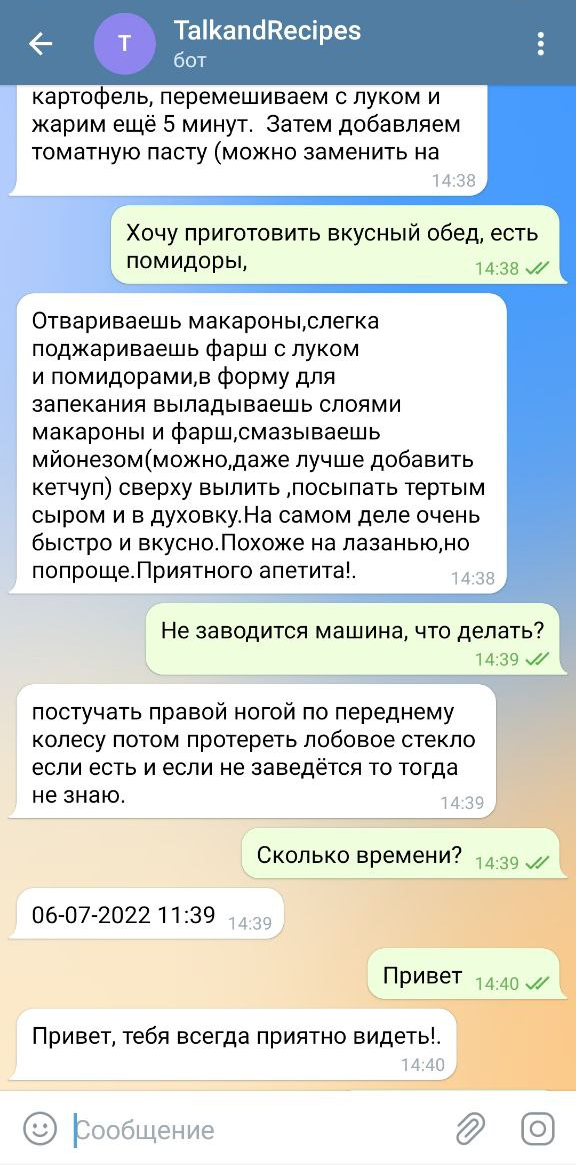

In [ ]:
from IPython.display import Image
Image('bot.png')